In [1]:
import data_processing
import models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras import optimizers
from keras.models import Model
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [15]:
# load pre-trained GloVe
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-07-21 20:14:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.09MB/s    in 2m 40s  

2022-07-21 20:17:19 (5.15 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [2]:
# mount Google Drive
ROOT = "/content/drive"
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# read csv in as df
inputPath = '/content/drive/MyDrive/GitHub/Home/Financial/Data/pos_expenses_data1.csv'
df = data_processing.load_purchase_attributes(inputPath)
df.head()

,Location,Description,Cost,Category,Day,Month,Year
0,BurgerKing,dinner,2.19,restaurant,15,May,2019
1,Dennys,late night/early morning food for both sam and i,24.76,restaurant,17,May,2019
2,Dennys,tip,4.95,restaurant,17,May,2019
3,Wawa,moving truck fuel,27.50,transportation,17,May,2019
4,Exxon,moving truck fuel,78.25,transportation,17,May,2019


In [4]:
# define data types for columns
new_df_schema = {
'Location': df['Location'].astype(str),
'Description': df['Description'].astype(str),
'Cost': pd.to_numeric(df['Cost']),
'Category': df['Category'].astype(str),
'Day': df['Day'].astype(str),
'Month': df['Month'].astype(str),
'Year': df['Year'].astype(str),
}

# update the data types
df = pd.DataFrame(new_df_schema)

In [5]:
# drop Category and Description data for mlp
X_MLP = df.drop(['Description', 'Category'], axis=1)
# separate Description data for cnn
X_CNN = df['Description']
# set trainY and testY to Category
Y = df['Category']
# get classes from Category
class_names = pd.unique(df['Category'])

In [6]:
# partition the data into training and testing splits using 75% of the data for 
# training and the remaining 25% for testing
split = train_test_split(X_MLP, X_CNN, Y, test_size=0.25, random_state=42)
(trainX_MLP, testX_MLP, trainX_CNN, testX_CNN, trainY, testY) = split
# process the purchase attributes data by performing min-max scaling on
# continuous features, one-hot encoding on categorical features, and then
# finally concatenating them together
(trainX_MLP, testX_MLP) = data_processing.process_purchase_attributes(X_MLP, trainX_MLP, testX_MLP)
X = data_processing.process_purchase_attributes_all(X_MLP)
# one-hot encode Y
Y = np.array(Y).reshape(-1, 1)
trainY = np.array(trainY).reshape(-1, 1)
testY = np.array(testY).reshape(-1, 1)
(trainY, testY) = data_processing.process_purchase_labels(Y, trainY, testY)

In [7]:
# process Description data and create embedding layer for cnn
voc, word_index, vectorizer = data_processing.create_vocab_index(trainX_CNN)
embeddings_index = data_processing.create_embeddings_index()
num_tokens, embedding_dim, embedding_matrix = data_processing.create_embedding_matrix(
    voc, word_index, embeddings_index)

In [8]:
# vectorize cnn input
trainX_CNN = vectorizer(np.array([[s] for s in trainX_CNN])).numpy()
testX_CNN = vectorizer(np.array([[s] for s in testX_CNN])).numpy()

In [9]:
# create the MLP and CNN models
mlp = models.create_mlp_multi(trainX_MLP.shape[1])
cnn = models.create_cnn_multi(num_tokens, embedding_dim, embedding_matrix, class_names, 128)
# create the combined model
model = models.create_multi(mlp, cnn, class_names)

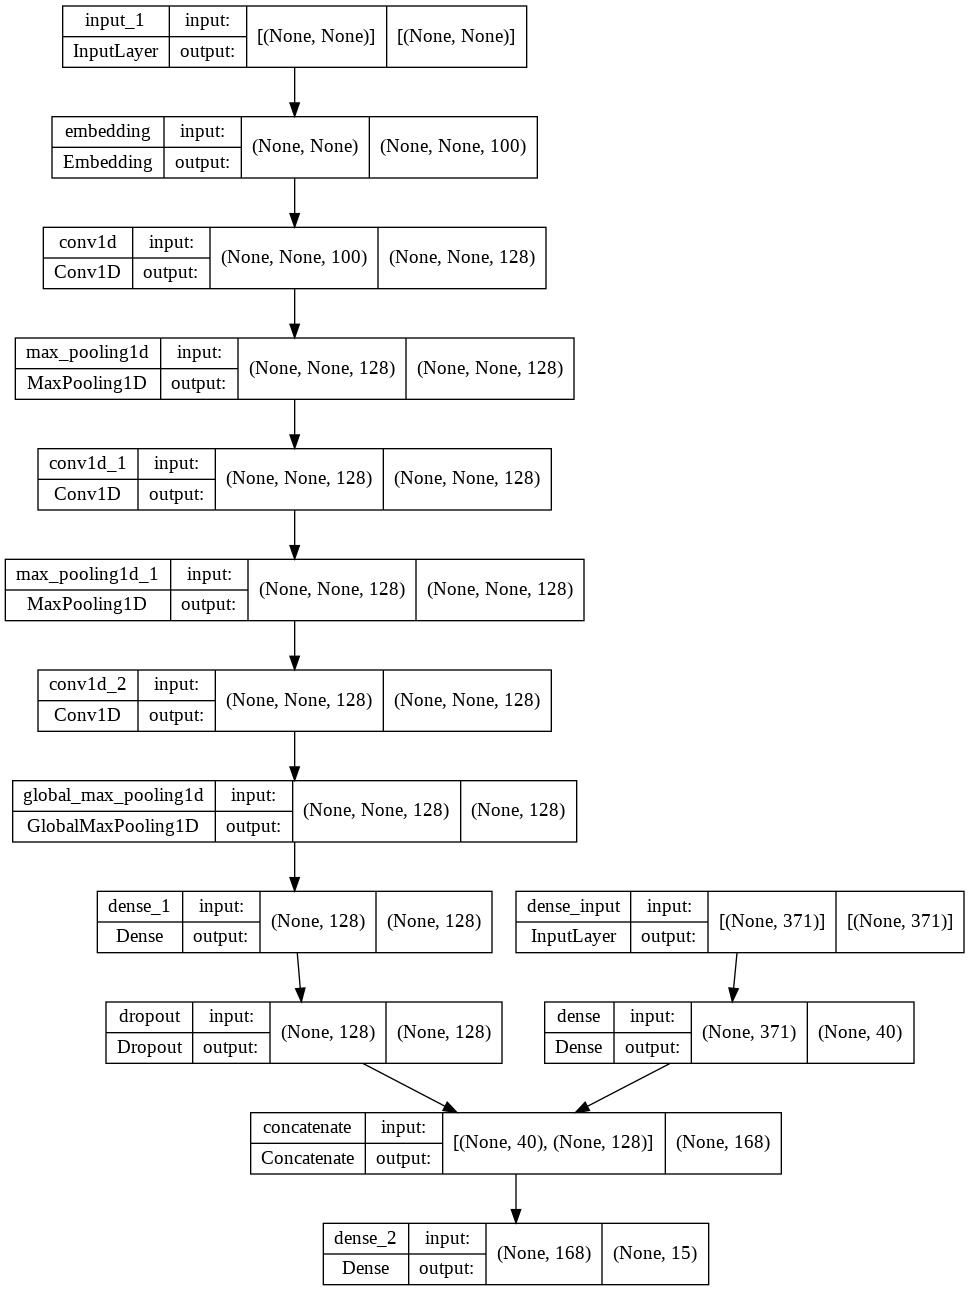

In [10]:
# plot the combined model
plot_model(model, to_file='combined-model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# compile the model using categorical crossentropy loss
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
# train the model
history = model.fit(
	x=[trainX_MLP, trainX_CNN], y=trainY,
	validation_data=([testX_MLP, testX_CNN], testY),
	epochs=20, batch_size=64)
# make predictions on the testing data
preds = model.predict([testX_MLP, testX_CNN])

Epoch 1/20
34/34 [==============================] - 6s 139ms/step - loss: 1.8255 - acc: 0.5265 - val_loss: 1.0891 - val_acc: 0.6775
Epoch 2/20
34/34 [==============================] - 4s 130ms/step - loss: 1.0149 - acc: 0.7083 - val_loss: 0.8450 - val_acc: 0.7465
Epoch 3/20
34/34 [==============================] - 4s 133ms/step - loss: 0.8212 - acc: 0.7454 - val_loss: 0.7559 - val_acc: 0.7775
Epoch 4/20
34/34 [==============================] - 11s 336ms/step - loss: 0.6906 - acc: 0.7900 - val_loss: 0.6513 - val_acc: 0.8211
Epoch 5/20
34/34 [==============================] - 8s 241ms/step - loss: 0.5647 - acc: 0.8384 - val_loss: 0.5708 - val_acc: 0.8268
Epoch 6/20
34/34 [==============================] - 9s 265ms/step - loss: 0.4623 - acc: 0.8643 - val_loss: 0.5088 - val_acc: 0.8408
Epoch 7/20
34/34 [==============================] - 9s 261ms/step - loss: 0.3841 - acc: 0.8901 - val_loss: 0.4678 - val_acc: 0.8648
Epoch 8/20
34/34 [==============================] - 10s 309ms/step - loss: 

epochs=20, batch_size=64
Test loss: 0.4294756352901459
Test accuracy: 0.902816891670227


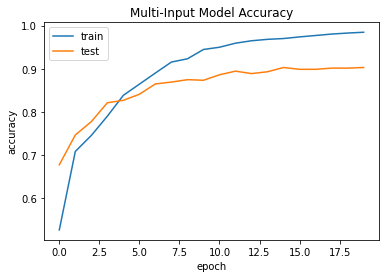

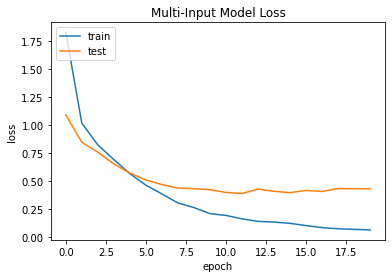

In [12]:
# print loss and accuracy, then plot
print('epochs=20, batch_size=64')
score = model.evaluate([testX_MLP, testX_CNN], testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Multi-Input Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Multi-Input Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# create the MLP and CNN models
mlp = models.create_mlp_multi(trainX_MLP.shape[1])
cnn = models.create_cnn_multi(num_tokens, embedding_dim, embedding_matrix, class_names, 128)
# create the combined model
model = models.create_multi(mlp, cnn, class_names)

In [14]:
# compile the model using categorical crossentropy loss
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
# train the model
history1 = model.fit(
	x=[trainX_MLP, trainX_CNN], y=trainY,
	validation_data=([testX_MLP, testX_CNN], testY),
	epochs=20, batch_size=16)
# make predictions on the testing data
preds = model.predict([testX_MLP, testX_CNN])

Epoch 1/20
134/134 [==============================] - 6s 42ms/step - loss: 1.2568 - acc: 0.6364 - val_loss: 0.8474 - val_acc: 0.7563
Epoch 2/20
134/134 [==============================] - 8s 63ms/step - loss: 0.7737 - acc: 0.7802 - val_loss: 0.6853 - val_acc: 0.7944
Epoch 3/20
134/134 [==============================] - 10s 78ms/step - loss: 0.5397 - acc: 0.8502 - val_loss: 0.5511 - val_acc: 0.8535
Epoch 4/20
134/134 [==============================] - 10s 75ms/step - loss: 0.3862 - acc: 0.8948 - val_loss: 0.4535 - val_acc: 0.8803
Epoch 5/20
134/134 [==============================] - 7s 52ms/step - loss: 0.2756 - acc: 0.9300 - val_loss: 0.4222 - val_acc: 0.8915
Epoch 6/20
134/134 [==============================] - 5s 41ms/step - loss: 0.1987 - acc: 0.9465 - val_loss: 0.4540 - val_acc: 0.8972
Epoch 7/20
134/134 [==============================] - 5s 41ms/step - loss: 0.1681 - acc: 0.9587 - val_loss: 0.4063 - val_acc: 0.8958
Epoch 8/20
134/134 [==============================] - 6s 41ms/step 

epochs=20, batch_size=16
Test loss: 0.4022718369960785
Test accuracy: 0.9211267828941345


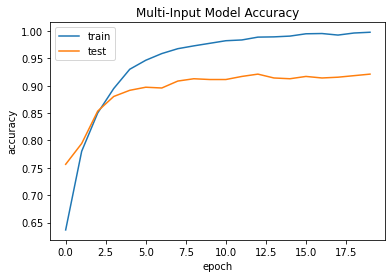

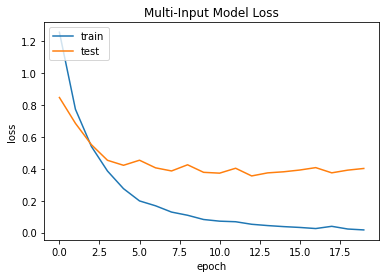

In [15]:
# print loss and accuracy, then plot
print('epochs=20, batch_size=16')
score = model.evaluate([testX_MLP, testX_CNN], testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# summarize history for accuracy
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Multi-Input Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Multi-Input Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# create the MLP and CNN models
mlp = models.create_mlp_multi(trainX_MLP.shape[1])
cnn = models.create_cnn_multi(num_tokens, embedding_dim, embedding_matrix, class_names, 128)
# create the combined model
model = models.create_multi(mlp, cnn, class_names)

In [17]:
# compile the model using categorical crossentropy loss
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
# train the model
history = model.fit(
	x=[trainX_MLP, trainX_CNN], y=trainY,
	validation_data=([testX_MLP, testX_CNN], testY),
	epochs=10, batch_size=16)
# make predictions on the testing data
preds = model.predict([testX_MLP, testX_CNN])

Epoch 1/10
134/134 [==============================] - 7s 45ms/step - loss: 1.2789 - acc: 0.6303 - val_loss: 0.8116 - val_acc: 0.7366
Epoch 2/10
134/134 [==============================] - 7s 55ms/step - loss: 0.7472 - acc: 0.7750 - val_loss: 0.6406 - val_acc: 0.8042
Epoch 3/10
134/134 [==============================] - 6s 42ms/step - loss: 0.5247 - acc: 0.8464 - val_loss: 0.5087 - val_acc: 0.8676
Epoch 4/10
134/134 [==============================] - 6s 42ms/step - loss: 0.3695 - acc: 0.9014 - val_loss: 0.4295 - val_acc: 0.8915
Epoch 5/10
134/134 [==============================] - 6s 42ms/step - loss: 0.2846 - acc: 0.9150 - val_loss: 0.4371 - val_acc: 0.8887
Epoch 6/10
134/134 [==============================] - 6s 42ms/step - loss: 0.2149 - acc: 0.9413 - val_loss: 0.4234 - val_acc: 0.9014
Epoch 7/10
134/134 [==============================] - 6s 42ms/step - loss: 0.1824 - acc: 0.9540 - val_loss: 0.3852 - val_acc: 0.9197
Epoch 8/10
134/134 [==============================] - 6s 42ms/step - 

epochs=10, batch_size=16
Test loss: 0.3692329525947571
Test accuracy: 0.9183098673820496


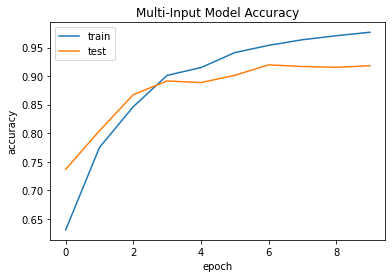

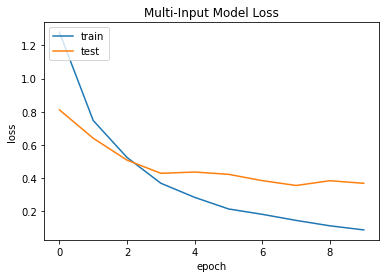

In [18]:
# print loss and accuracy, then plot
print('epochs=10, batch_size=16')
score = model.evaluate([testX_MLP, testX_CNN], testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Multi-Input Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Multi-Input Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# display results
preds = model.predict([testX_MLP, testX_CNN])
pred_df = pd.DataFrame(preds, columns = ['alcohol', 'business',	'clothes',	'education',	'entertainment',	'grocery',	'health', 'hygiene', 'improvement',	'misc',	'rent',	'restaurant',	'supplies',	'transportation',	'utilities'])
pred_df = pred_df.idxmax(axis=1)[:30]

label_df = pd.DataFrame(testY, columns = ['alcohol', 'business',	'clothes',	'education',	'entertainment',	'grocery',	'health',	'hygiene', 'improvement',	'misc',	'rent',	'restaurant',	'supplies',	'transportation',	'utilities'])
label_df = label_df.idxmax(axis=1)[:30]

split = train_test_split(X_MLP, X_CNN, test_size=0.25, random_state=42)
(train_MLP, test_MLP, train_CNN, test_CNN) = split

testCNN_df = pd.DataFrame(test_CNN).reset_index(drop=True)[:30]
testMLP_df = pd.DataFrame(test_MLP).reset_index(drop=True)[:30]
  
compare_df = pd.concat([testMLP_df, testCNN_df, pred_df, label_df], axis=1)
compare_df.columns =['Location', 'Cost', 'Day', 'Month', 'Year', 'Description', 'Predicted', 'Actual']

print(compare_df)